In [2]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [8]:
#path = '/well/woolrich/projects/disp_csaky/opm_lukas/raw_preproc_mark_mfc.fif'
#path = '/well/woolrich/projects/disp_csaky/OPM/11766_reading/osl/raw_preproc.fif'
path = '/well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/highpass_4hz/raw_preproc_mfc.fif'
raw = mne.io.read_raw_fif(path, preload=True)
#raw_old = mne.io.read_raw_fif(path, preload=True)

Opening raw data file /well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/highpass_4hz/raw_preproc_mfc.fif...
Isotrak not found


/tmp/ipykernel_6310/2850337956.py:4: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/highpass_4hz/raw_preproc_mfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path, preload=True)


    Range : 0 ... 291879 =      0.000 ...  2918.790 secs
Ready.
Reading 0 ... 291879  =      0.000 ...  2918.790 secs...


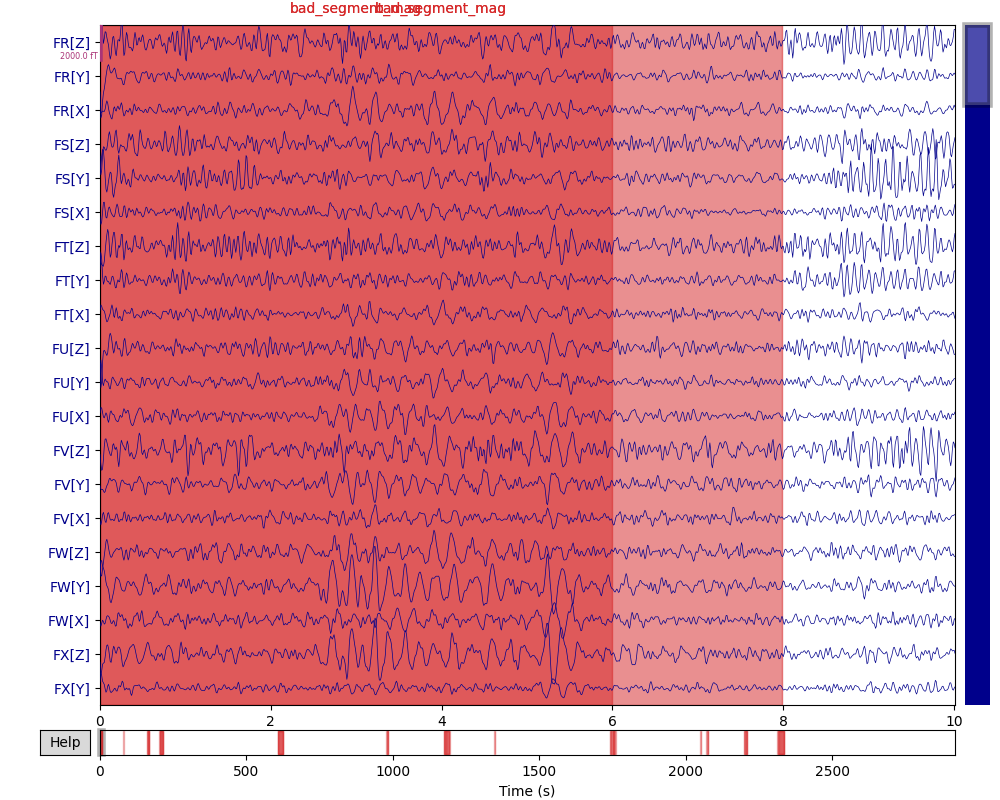

In [9]:
%matplotlib widget
raw.plot()
e=0

Setting 14399 of 291880 (4.93%) samples to NaN, retaining 277481 (95.07%) samples.
Effective window size : 5.000 (s)


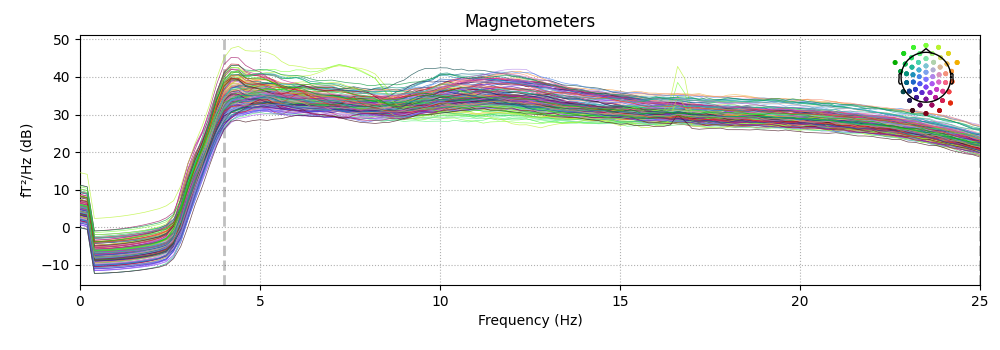

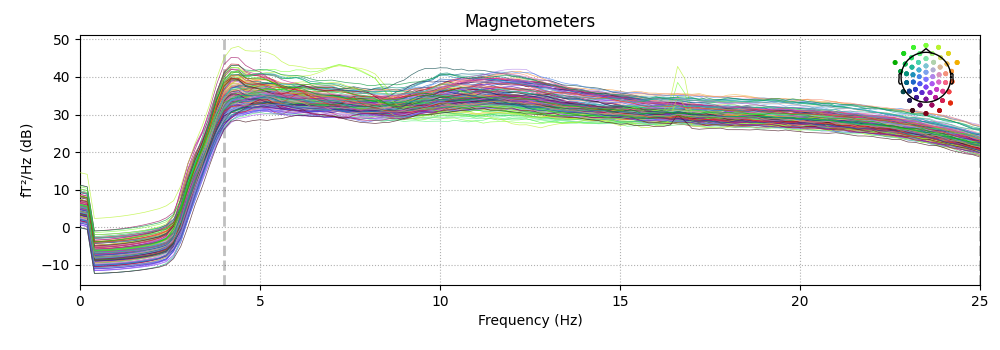

In [10]:
%matplotlib widget
raw.compute_psd(fmax=25, n_fft=500).plot()
e=0

In [ ]:
lang_channels = ['LR', 'LF', 'LE', 'LN', 'KG', 'LM', 'KI', 'KF', 'KH', 'LA',
                 'FR', 'FV', 'FU', 'FS', 'G2', 'G0', 'HQ', 'HE', 'FX', 'I4']

# extract indices from raw.ch_names if lang_channels name is in the string of raw.ch_names
lang_indices = [str(i) for i, s in enumerate(raw.ch_names) if any(xs in s for xs in lang_channels)]

In [ ]:
print(','.join(lang_indices))

In [ ]:
raw.plot_sensors(show_names=True)

In [13]:
# get sensor orientations
ors = [raw.info['chs'][i]['loc'][-3:] for i in range(len(raw.info['chs']))]
ors = np.array(ors)

In [37]:
channels = pd.read_csv('/well/woolrich/projects/disp_csaky/opm_lukas/20221019_085012_channels.tsv', sep='\t')

In [38]:
# get Ox, Oy, Oz orientations from channels.tsv based on raw.ch_names
Ox = channels.loc[channels['name'].isin(raw.ch_names), 'Ox'].values
Oy = channels.loc[channels['name'].isin(raw.ch_names), 'Oy'].values
Oz = channels.loc[channels['name'].isin(raw.ch_names), 'Oz'].values

ors = np.vstack((Ox, Oy, Oz)).T

In [14]:
ors.shape

(162, 3)

In [5]:
# eye(length(ors)) - ors*pinv(ors)
eye = np.eye(len(ors))
pinv = np.linalg.pinv(ors)
mfc = eye - ors @ pinv

In [6]:
# apply mfc to the raw object through raw.apply_function()
fun = lambda x: mfc @ (x - np.mean(x, axis=1, keepdims=True))
raw.apply_function(fun, channel_wise=False)

<Raw | raw_preproc.fif, 164 x 303480 (3034.8 s), ~379.9 MB, data loaded>

In [ ]:
mne.set_config('MNE_BROWSE_RAW_SIZE', '16,9')

In [7]:
raw.save('/well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc_mfc.fif', overwrite=True)

Writing /well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc_mfc.fif


/tmp/ipykernel_14459/3315037113.py:1: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc_mfc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('/well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc_mfc.fif', overwrite=True)


Closing /well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc_mfc.fif
[done]


In [57]:
dataset_path = "/gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg.fif"
raw_raw = mne.io.read_raw_fif(dataset_path, preload=True)

Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg.fif...
Isotrak not found
    Range : 0 ... 2642399 =      0.000 ...  2201.999 secs
Ready.
Opening raw data file /gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg-1.fif...
Isotrak not found
    Range : 2642400 ... 3502559 =   2202.000 ...  2918.799 secs
Ready.
Reading 0 ... 3502559  =      0.000 ...  2918.799 secs...


Using matplotlib as 2D backend.


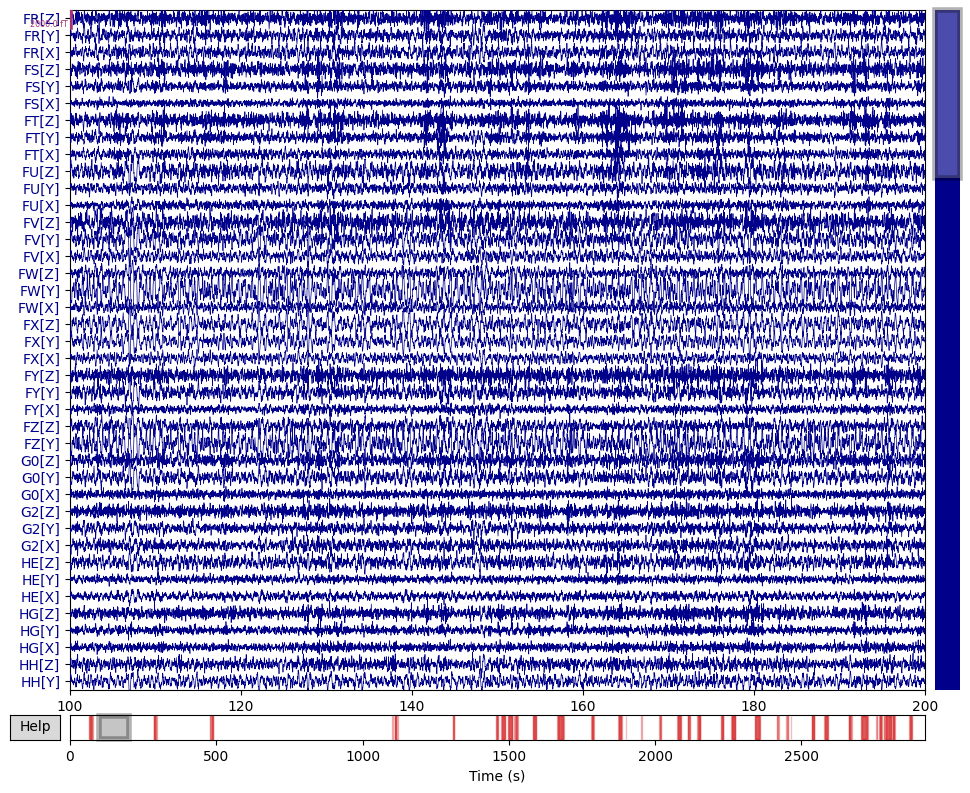

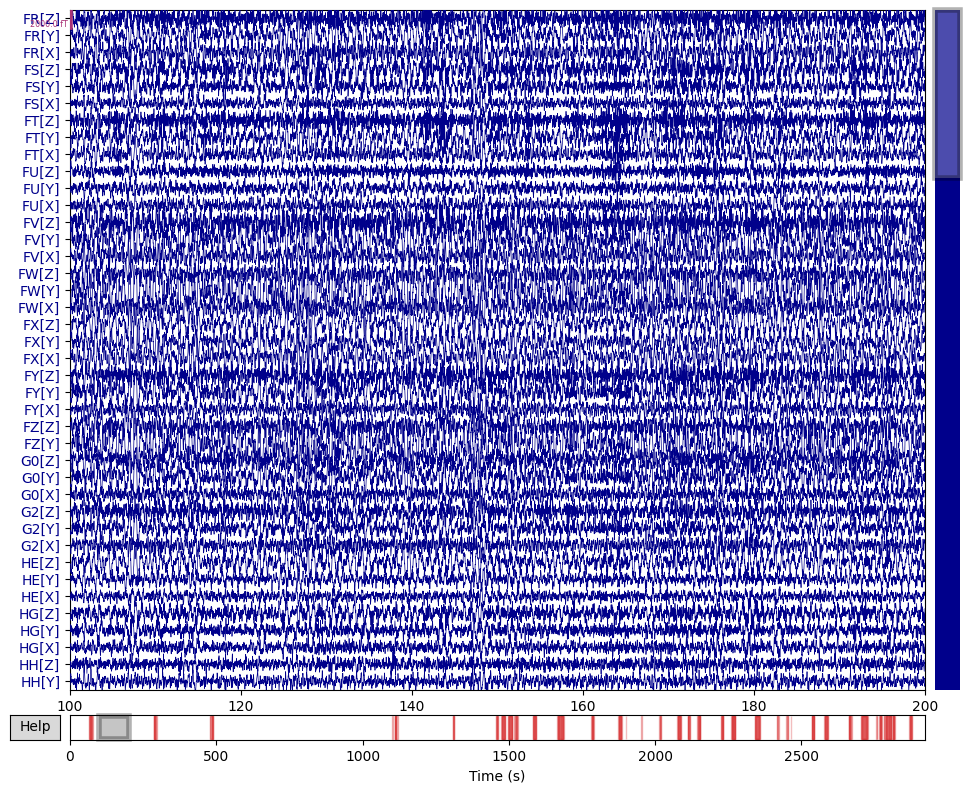

In [10]:
# check whether the mfc is applied correctly
%matplotlib inline
raw.plot(n_channels=40, start=100, duration=100)
raw_old.plot(n_channels=40, start=100, duration=100)
e=0

In [9]:
# load events.fif
events = mne.read_events('/gpfs2/well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_events.fif')

# sort by time
events = events[np.argsort(events[:, 0])]

# divide time by 12 and round to int
events[:, 0] = events[:, 0] // 12

/tmp/ipykernel_14459/3111531753.py:2: RuntimeWarning: This filename (/gpfs2/well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_events.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events('/gpfs2/well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_events.fif')


In [10]:
event_dict = {'words/hungry': 2,
              'words/tired': 3,
              'words/thirsty': 4,
              'words/toilet': 5,
              'words/pain': 6}

outdir = '/well/woolrich/projects/disp_csaky/OPM/13703_reading/sub_preproc25hz'

In [11]:
epochs = mne.Epochs(raw,
                    events,
                    event_id=event_dict,
                    tmin=-0.1,
                    tmax=1.6,
                    baseline=None,
                    reject=None,
                    preload=True)

for epoch, event in zip(epochs, epochs.events):
    data = epoch.T.astype(np.float32)

    event_id = event[-1]
    os.makedirs(f"{outdir}/cond{event_id-2}", exist_ok=True)
    n_trials = int(len(os.listdir(f"{outdir}/cond{event_id-2}")))
    if n_trials < 205:
        np.save(f"{outdir}/cond{event_id-2}/trial{n_trials}.npy", data)

Not setting metadata
1300 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1300 events and 171 original time points ...
181 bad epochs dropped
